In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [6]:
name = 'Spencer_Johnson_vs._A&M_1_17.csv'
athlete = 'Spencer Johnson'
data = pd.read_csv(name)

In [7]:
# Filtering columns
serve_data = data[((data['firstServeIn'] > 0) | (data['secondServeIn'] > 0)) & (data['serverName'] == athlete)][['pointScore','firstServeIn',
       'firstServeZone',
       'secondServeIn', 'secondServeZone']]

# Creating ad and deuce df
df_deuce = serve_data[serve_data['pointScore'].str.contains('Deuce')]
df_ad = serve_data[serve_data['pointScore'].str.contains('Advantage')]

# Converting pointScore
serve_data = serve_data[~serve_data['pointScore'].str.contains('Deuce|Advantage')]
serve_data[['server_points', 'receiver_points']] = serve_data['pointScore'].str.split('-', expand=True)
serve_data['server_points'] = pd.to_numeric(serve_data['server_points'], errors='coerce')
serve_data['receiver_points'] = pd.to_numeric(serve_data['receiver_points'], errors='coerce')

# Determining if point is won
serve_data['pointsWon'] = 0
serve_data['pointsWon'] = (serve_data['server_points'].shift(-1) > serve_data['server_points']).astype(int)
serve_data = serve_data[['pointsWon'] + [col for col in serve_data.columns if col != 'pointsWon']]

# Simplifying points
POINTS = {0: 0, 15: 1, 30: 2, 40: 3}
serve_data['server_points'] = serve_data['server_points'].map(POINTS)
serve_data['receiver_points'] = serve_data['receiver_points'].map(POINTS)

# Computing odd or even total
serve_data['total_points_category'] = serve_data['server_points'] + serve_data['receiver_points']
df_even = serve_data[serve_data['total_points_category'] % 2 == 0]
df_odd = serve_data[serve_data['total_points_category'] % 2 != 0]

# final dataset
df_ad = pd.concat([df_ad, df_odd])
df_deuce = pd.concat([df_deuce, df_even])
df_ad = df_ad[['pointScore','firstServeIn',
       'firstServeZone',
       'secondServeIn', 'secondServeZone', 'pointsWon']]
df_deuce = df_deuce[['pointScore','firstServeIn',
       'firstServeZone',
       'secondServeIn', 'secondServeZone', 'pointsWon']]

# Processing final dataset for graphing
df_ad.loc[df_ad['firstServeIn'] == 0, 'firstServeIn'] = df_ad['secondServeIn']
df_ad.loc[df_ad['firstServeIn'] == 0, 'firstServeZone'] = df_ad['secondServeZone']
df_deuce.loc[df_deuce['firstServeIn'] == 0, 'firstServeIn'] = df_deuce['secondServeIn']
df_deuce.loc[df_deuce['firstServeIn'] == 0, 'firstServeZone'] = df_deuce['secondServeZone']
df_ad = df_ad[['firstServeIn','firstServeZone', 'pointsWon']]
df_deuce = df_deuce[['firstServeIn','firstServeZone', 'pointsWon']]


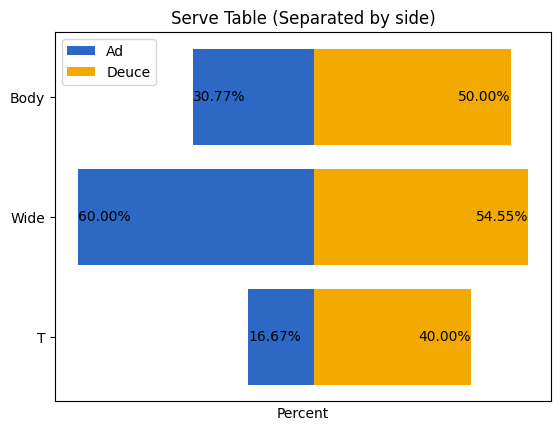

In [13]:
categories = ['T', 'Wide', 'Body']
ad = df_ad.groupby('firstServeZone')['pointsWon'].mean().reset_index().iloc[:, 1] * 100
deuce = df_deuce.groupby('firstServeZone')['pointsWon'].mean().reset_index().iloc[:, 1] * 100

fig = plt.figure()
ax = fig.add_subplot()

bars_left = ax.barh(categories, -ad, color='#2D68C4', label='Ad', align='center')
bars_right = ax.barh(categories, deuce, color='#F2AA00', label='Deuce', align='center')

for bar in bars_left:
    width = bar.get_width()
    plt.text(width, bar.get_y() + bar.get_height() / 2, f'{abs(width):.2f}%', ha='left', va='center')

for bar in bars_right:
    width = bar.get_width()
    plt.text(width, bar.get_y() + bar.get_height() / 2, f'{width:.2f}%', ha='right', va='center')

ax.set_xticks([])
ax.set_xlabel('Percent')
ax.set_title('Serve Table (Separated by side)')
ax.legend()

plt.show()
